In [17]:
# P2P — Event Log EDA (days)
# Explore: schema, activities, cases, durations, next-time deltas, variants, DFG pairs, timelines.

In [52]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
DATASET = "P2P"
PATH = "/ceph/lfertig/Thesis/data/P2P/raw/df_p2p.csv.gz"
CASE_COL = "case:concept:name"
ACT_COL  = "concept:name"
TIME_COL = "time:timestamp"

In [20]:
df = pd.read_csv(PATH, low_memory=False)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.info()
display(df.head(25))

Shape: (9119, 6)
Columns: ['case:concept:name', 'concept:name', 'concept:name.1', 'time:timestamp', '@@index', '@@case_index']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   case:concept:name  9119 non-null   int64 
 1   concept:name       9119 non-null   object
 2   concept:name.1     9119 non-null   object
 3   time:timestamp     9119 non-null   object
 4   @@index            9119 non-null   int64 
 5   @@case_index       9119 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 427.6+ KB


,case:concept:name,concept:name,concept:name.1,time:timestamp,@@index,@@case_index
0,1,Create Purchase Requisition,Create Purchase Requisition,2011-01-01 05:37:00+00:00,0,0
1,1,Create Request for Quotation,Create Request for Quotation,2011-01-01 10:45:00+00:00,1,1
2,1,Analyze Request for Quotation,Analyze Request for Quotation,2011-01-01 11:55:00+00:00,2,2
3,1,Send Request for Quotation to Supplier,Send Request for Quotation to Supplier,2011-01-01 17:09:00+00:00,3,3
4,1,Create Quotation comparison Map,Create Quotation comparison Map,2011-01-01 21:03:00+00:00,4,4
5,1,Analyze Quotation Comparison Map,Analyze Quotation Comparison Map,2011-01-02 04:13:00+00:00,5,5
6,1,Choose best option,Choose best option,2011-01-02 04:13:00+00:00,6,6
7,1,Settle Conditions With Supplier,Settle Conditions With Supplier,2011-01-02 14:20:00+00:00,7,7
8,1,Create Purchase Order,Create Purchase Order,2011-01-02 15:10:00+00:00,8,8
9,1,Confirm Purchase Order,Confirm Purchase Order,2011-01-02 19:43:00+00:00,9,9


In [21]:
# Parse timestamps, basic sanity checks, sort
assert CASE_COL in df.columns and ACT_COL in df.columns and TIME_COL in df.columns, "Expected columns missing."
df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True, errors="coerce")
assert df[TIME_COL].notna().any(), "All timestamps are NaT—check the time column."
df = df.sort_values([CASE_COL, TIME_COL]).reset_index(drop=True)

# High-level counts
n_events = len(df)
n_cases  = df[CASE_COL].nunique()
n_acts   = df[ACT_COL].nunique()
print(f"Events: {n_events:,} | Cases: {n_cases:,} | Activities: {n_acts:,}")

Events: 9,119 | Cases: 608 | Activities: 21


,count,mean,std,min,50%,90%,95%,99%,max
events_per_case,608.0,14.998355,8.163183,2.0,18.0,24.0,26.0,29.93,44.0


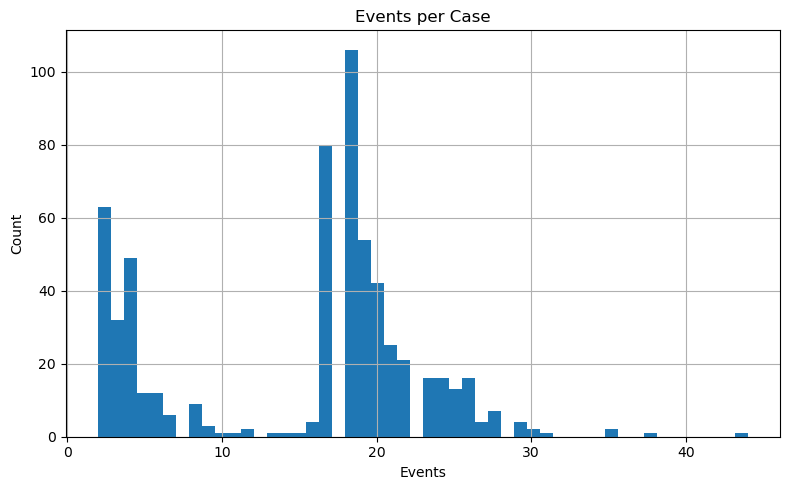

In [22]:
# Events per case
ev_per_case = df.groupby(CASE_COL, sort=False).size().rename("events_per_case")
ev_stats = ev_per_case.describe(percentiles=[0.5, 0.9, 0.95, 0.99])
display(ev_stats.to_frame().T)

plt.figure(figsize=(8,5))
plt.hist(ev_per_case, bins=50)
plt.title("Events per Case"); plt.xlabel("Events"); plt.ylabel("Count")
plt.grid(True); plt.tight_layout(); plt.show()

,count,mean,std,min,50%,90%,95%,99%,max
case_duration_days,608.0,21.437791,28.679109,0.408333,11.902083,81.832847,90.305104,103.788764,108.279861


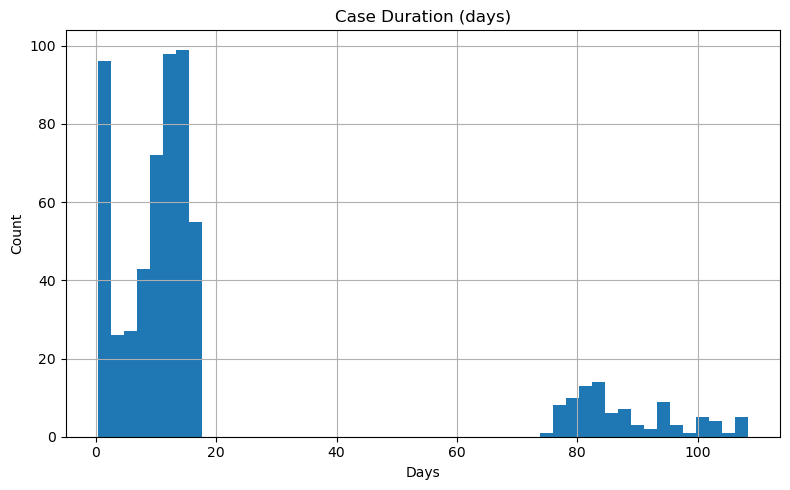

,days
case:concept:name,
655,108.279861
1160,107.684028
892,107.552083
1025,106.808333
635,106.472917
632,104.324306
223,103.802083
872,103.611806
1284,102.327083


,days
case:concept:name,
1949,0.408333
1892,0.427778
1305,0.428472
1367,0.429167
1395,0.457639
1057,0.464583
1871,0.468750
1852,0.490278
423,0.490972


In [23]:
# Case durations (days): end - start per case
g = df.groupby(CASE_COL, sort=False)[TIME_COL]
case_start = g.min()
case_end   = g.max()
case_duration_days = (case_end - case_start).dt.total_seconds() / 86400.0
dur_stats = case_duration_days.describe(percentiles=[0.5, 0.9, 0.95, 0.99]).rename("case_duration_days")
display(dur_stats.to_frame().T)

plt.figure(figsize=(8,5))
plt.hist(case_duration_days, bins=50)
plt.title("Case Duration (days)"); plt.xlabel("Days"); plt.ylabel("Count")
plt.grid(True); plt.tight_layout(); plt.show()

# Top/bottom cases by duration
display(case_duration_days.sort_values(ascending=False).head(10).to_frame("days"))
display(case_duration_days.sort_values(ascending=True).head(10).to_frame("days"))

,count,mean,std,min,50%,90%,95%,99%,max
next_time_delta_days,8511.0,1.531451,4.80904,0.0,0.341667,2.906944,5.861111,26.541042,88.582639


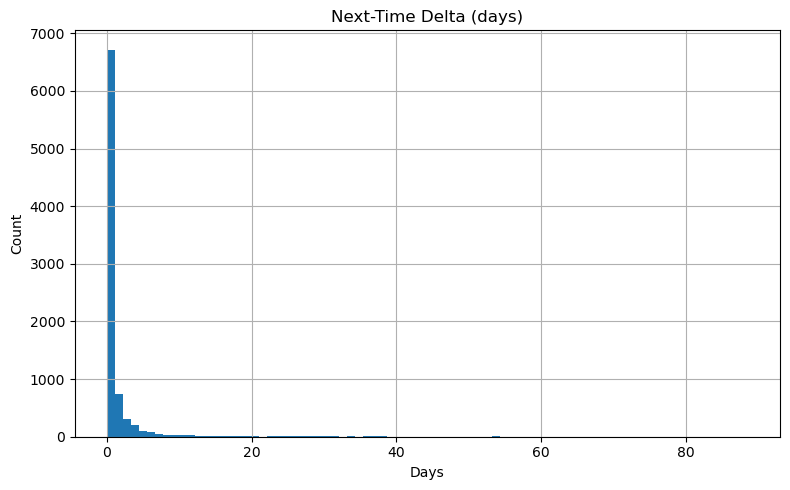

In [24]:
# Next-time deltas (days): within-case differences between consecutive events
df["next_time_delta_days"] = (
    df.groupby(CASE_COL, sort=False)[TIME_COL]
      .diff()
      .dt.total_seconds() / 86400.0
)
ntd = df["next_time_delta_days"].dropna()
ntd_stats = ntd.describe(percentiles=[0.5, 0.9, 0.95, 0.99]).rename("next_time_delta_days")
display(ntd_stats.to_frame().T)

plt.figure(figsize=(8,5))
plt.hist(ntd, bins=80)
plt.title("Next-Time Delta (days)"); plt.xlabel("Days"); plt.ylabel("Count")
plt.grid(True); plt.tight_layout(); plt.show()

,case_starts
concept:name,
Create Purchase Requisition,608


,case_ends
concept:name,
Pay Invoice,413
Analyze Request for Quotation,131
Analyze Purchase Requisition,64


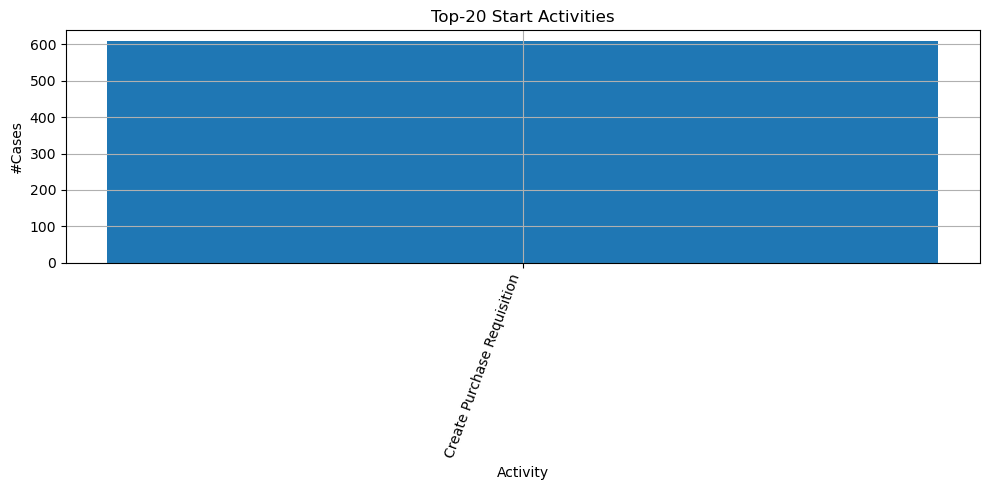

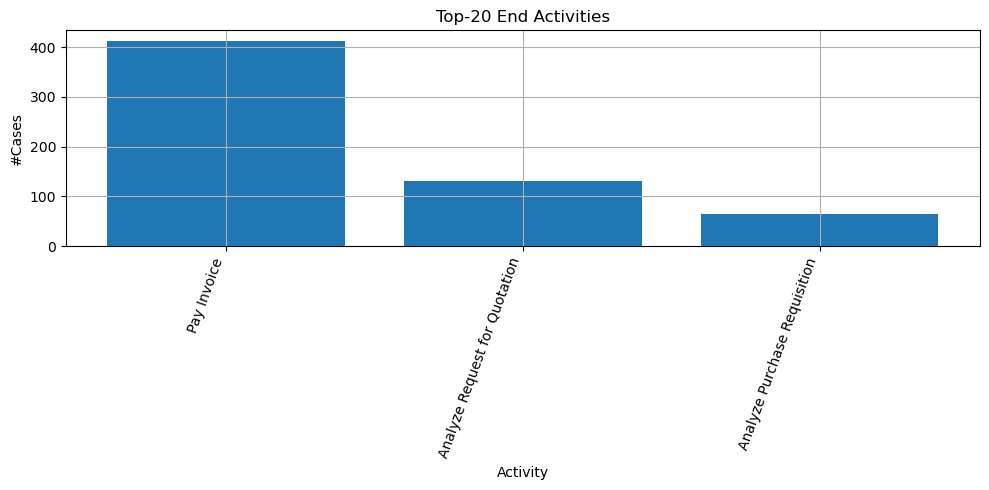

In [25]:
# Start/End activities
first_acts = df.groupby(CASE_COL, sort=False).first()[ACT_COL].value_counts()
last_acts  = df.groupby(CASE_COL, sort=False).last()[ACT_COL].value_counts()
display(first_acts.head(20).to_frame("case_starts"))
display(last_acts.head(20).to_frame("case_ends"))

plt.figure(figsize=(10,5))
plt.bar(first_acts.head(20).index.astype(str), first_acts.head(20).values)
plt.title("Top-20 Start Activities"); plt.xlabel("Activity"); plt.ylabel("#Cases")
plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.bar(last_acts.head(20).index.astype(str), last_acts.head(20).values)
plt.title("Top-20 End Activities"); plt.xlabel("Activity"); plt.ylabel("#Cases")
plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

,from,to,count
0,Analyze Request for Quotation,Amend Request for Quotation,563
1,Amend Request for Quotation,Analyze Request for Quotation,563
2,Create Request for Quotation,Analyze Request for Quotation,544
3,Authorize Supplier's Invoice payment,Pay Invoice,413
4,Approve Purchase Order for payment,Send Invoice,413
5,Release Purchase Order,Approve Purchase Order for payment,413
6,Deliver Goods Services,Release Purchase Order,413
7,Confirm Purchase Order,Deliver Goods Services,413
8,Settle Conditions With Supplier,Create Purchase Order,413
9,Choose best option,Settle Conditions With Supplier,413


/tmp/ipykernel_1549237/1736435071.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()


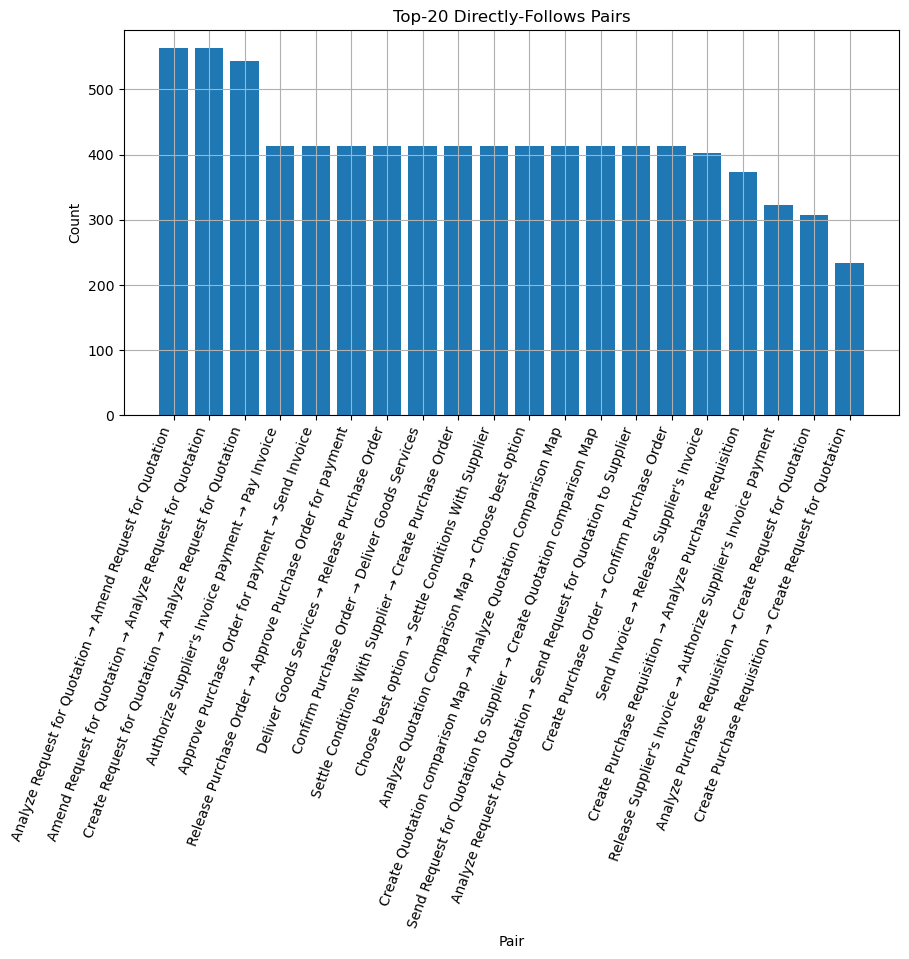

In [26]:
# Directly-Follows Graph (DFG) counts: bigrams within cases
def dfg_counts(df, case_col, act_col):
    pairs = []
    for _, g in df.groupby(case_col, sort=False):
        acts = g[act_col].dropna().tolist()
        if len(acts) > 1:
            pairs.extend(zip(acts[:-1], acts[1:]))

    s = pd.Series(pairs)
    vc = s.value_counts()  # index: tuples like ('A','B'), values: counts

    # Make it a MultiIndex so we can name the levels and reset cleanly
    vc.index = pd.MultiIndex.from_tuples(vc.index, names=["from", "to"])
    dfg_df = vc.reset_index(name="count")
    return dfg_df

dfg_df = dfg_counts(df, CASE_COL, ACT_COL)
display(dfg_df.head(20))

plt.figure(figsize=(10,5))
top_pairs = dfg_df.head(20)
labels = [f"{a} \u2192 {b}" for a, b in zip(top_pairs["from"], top_pairs["to"])]
plt.bar(labels, top_pairs["count"].values)
plt.title("Top-20 Directly-Follows Pairs"); plt.xlabel("Pair"); plt.ylabel("Count")
plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

/tmp/ipykernel_1549237/3733048281.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(case_variant)


,count,cumulative_coverage
Create Purchase Requisition → Analyze Purchase Requisition → Create Request for Quotation → Analyze Request for Quotation → Send Request for Quotation to Supplier → Create Quotation comparison Map → Analyze Quotation Comparison Map → Choose best option → Settle Conditions With Supplier → Create Purchase Order → Confirm Purchase Order → Deliver Goods Services → Release Purchase Order → Approve Purchase Order for payment → Send Invoice → Release Supplier's Invoice → Authorize Supplier's Invoice payment → Pay Invoice,88,0.144737
Create Purchase Requisition → Create Request for Quotation → Analyze Request for Quotation → Send Request for Quotation to Supplier → Create Quotation comparison Map → Analyze Quotation Comparison Map → Choose best option → Settle Conditions With Supplier → Create Purchase Order → Confirm Purchase Order → Deliver Goods Services → Release Purchase Order → Approve Purchase Order for payment → Send Invoice → Release Supplier's Invoice → Authorize Supplier's Invoice payment → Pay Invoice,77,0.271382
Create Purchase Requisition → Analyze Purchase Requisition,63,0.375000
Create Purchase Requisition → Analyze Purchase Requisition → Create Request for Quotation → Analyze Request for Quotation,48,0.453947
Create Purchase Requisition → Create Request for Quotation → Analyze Request for Quotation,32,0.506579
Create Purchase Requisition → Analyze Purchase Requisition → Create Request for Quotation → Analyze Request for Quotation → Amend Request for Quotation → Analyze Request for Quotation → Send Request for Quotation to Supplier → Create Quotation comparison Map → Analyze Quotation Comparison Map → Choose best option → Settle Conditions With Supplier → Create Purchase Order → Confirm Purchase Order → Deliver Goods Services → Release Purchase Order → Approve Purchase Order for payment → Send Invoice → Release Supplier's Invoice → Authorize Supplier's Invoice payment → Pay Invoice,30,0.555921
Create Purchase Requisition → Analyze Purchase Requisition → Create Request for Quotation → Analyze Request for Quotation → Send Request for Quotation to Supplier → Create Quotation comparison Map → Analyze Quotation Comparison Map → Choose best option → Settle Conditions With Supplier → Create Purchase Order → Confirm Purchase Order → Deliver Goods Services → Release Purchase Order → Approve Purchase Order for payment → Send Invoice → Release Supplier's Invoice → Settle Dispute With Supplier → Authorize Supplier's Invoice payment → Pay Invoice,26,0.598684
Create Purchase Requisition → Create Request for Quotation → Analyze Request for Quotation → Amend Request for Quotation → Analyze Request for Quotation → Send Request for Quotation to Supplier → Create Quotation comparison Map → Analyze Quotation Comparison Map → Choose best option → Settle Conditions With Supplier → Create Purchase Order → Confirm Purchase Order → Deliver Goods Services → Release Purchase Order → Approve Purchase Order for payment → Send Invoice → Release Supplier's Invoice → Authorize Supplier's Invoice payment → Pay Invoice,21,0.633224
Create Purchase Requisition → Create Request for Quotation → Analyze Request for Quotation → Send Request for Quotation to Supplier → Create Quotation comparison Map → Analyze Quotation Comparison Map → Choose best option → Settle Conditions With Supplier → Create Purchase Order → Confirm Purchase Order → Deliver Goods Services → Release Purchase Order → Approve Purchase Order for payment → Send Invoice → Release Supplier's Invoice → Settle Dispute With Supplier → Authorize Supplier's Invoice payment → Pay Invoice,17,0.661184
Create Purchase Requisition → Create Request for Quotation → Analyze Request for Quotation → Amend Request for Quotation → Analyze Request for Quotation → Amend Request for Quotation → Analyze Request for Quotation → Send Request for Quotation to Supplier → Create Quotation comparison Map → Analyze Quotation Comparison Map → Choose best option → Settle Conditions With Supplier 

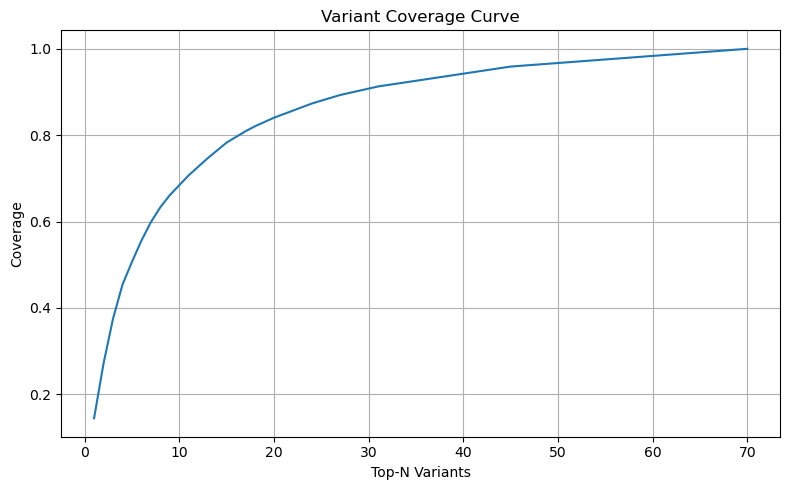

In [27]:
# Variants (activity sequences per case)
def case_variant(g):
    return " → ".join(g[ACT_COL].tolist())

variants = (
    df.groupby(CASE_COL, sort=False)
      .apply(case_variant)
      .value_counts()
)
coverage = (variants.cumsum() / variants.sum()).rename("cumulative_coverage")
top_variants = pd.concat([variants.rename("count"), coverage], axis=1).head(20)
display(top_variants)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(coverage)+1), coverage.values)
plt.title("Variant Coverage Curve"); plt.xlabel("Top-N Variants"); plt.ylabel("Coverage")
plt.grid(True); plt.tight_layout(); plt.show()

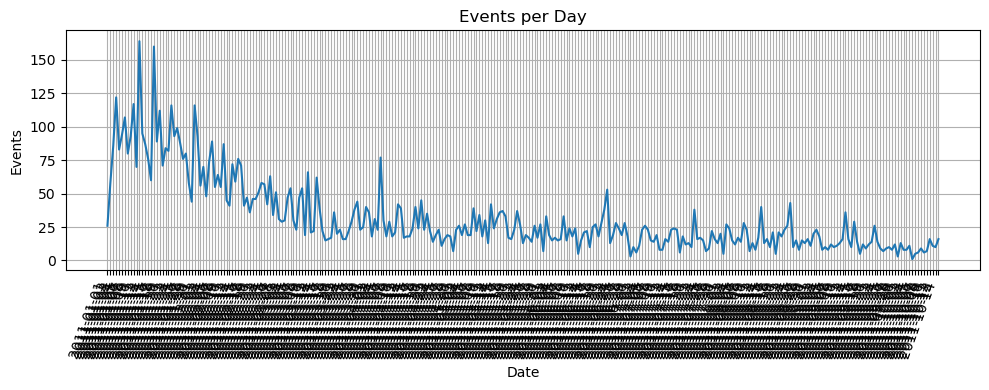

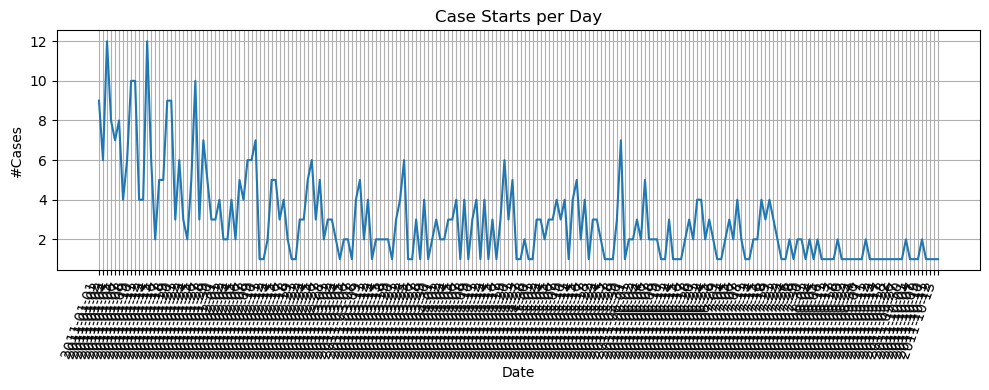

In [28]:
# Timeline views (event counts per day; case starts per day)
df["event_date"] = df[TIME_COL].dt.tz_convert(None).dt.date
events_per_day = pd.Series(df["event_date"]).value_counts().sort_index()
plt.figure(figsize=(10,4))
plt.plot(events_per_day.index.astype(str), events_per_day.values)
plt.title("Events per Day"); plt.xlabel("Date"); plt.ylabel("Events")
plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

case_start_date = case_start.dt.tz_convert(None).dt.date
starts_per_day = case_start_date.value_counts().sort_index()
plt.figure(figsize=(10,4))
plt.plot(starts_per_day.index.astype(str), starts_per_day.values)
plt.title("Case Starts per Day"); plt.xlabel("Date"); plt.ylabel("#Cases")
plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

In [29]:
# Missing values overview
na = df.isna().sum().sort_values(ascending=False)
display(na.to_frame("n_missing").T)

,next_time_delta_days,case:concept:name,concept:name,concept:name.1,time:timestamp,@@index,@@case_index,event_date
n_missing,608,0,0,0,0,0,0,0


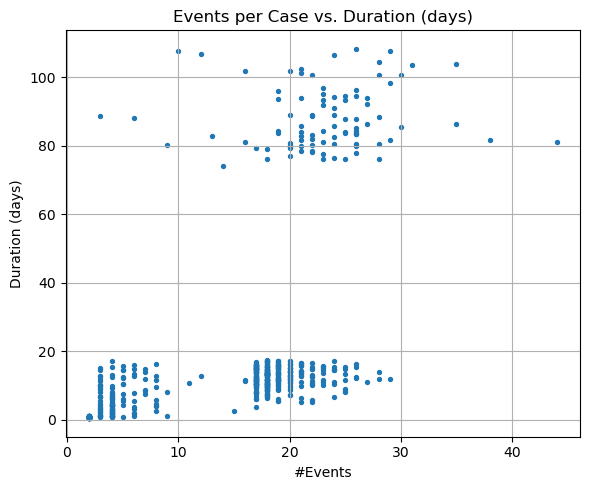

In [30]:
# Correlate events-per-case vs. duration (days) (quick scatter in matplotlib)
aligned = pd.DataFrame({
    "events_per_case": ev_per_case,
    "duration_days": case_duration_days
}).dropna()

plt.figure(figsize=(6,5))
plt.scatter(aligned["events_per_case"], aligned["duration_days"], s=8)
plt.title("Events per Case vs. Duration (days)")
plt.xlabel("#Events"); plt.ylabel("Duration (days)")
plt.grid(True); plt.tight_layout(); plt.show()

In [31]:
print("EDA complete.")

EDA complete.
